# Importing libraries

In [1]:
import time

start_time = time.time()

In [2]:
import sys
sys.path.append(r'c:\Users\928058\OneDrive - Royal HaskoningDHV\Documents\Coding_V2')

import Chicama as cma

# Simple inspection RAW NetCDF
Cell where we can simply inspect the NetCDF files' variables and attributes

In [3]:
# Create file path:
file_path = f'../Datasets/Maxima/maxima_1.nc'

# Open the dataset
dataset = cma.xr.open_dataset(file_path)

display(dataset)

<xarray.Dataset> Size: 9MB
Dimensions:                      (mesh2d_nNodes: 31380, mesh2d_nEdges: 62106,
                                  Two: 2, mesh2d_nFaces: 30727,
                                  mesh2d_nMax_face_nodes: 4)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 251kB ...
    mesh2d_node_y                (mesh2d_nNodes) float64 251kB ...
    mesh2d_edge_x                (mesh2d_nEdges) float64 497kB ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 497kB ...
    mesh2d_face_x                (mesh2d_nFaces) float64 246kB ...
    mesh2d_face_y                (mesh2d_nFaces) float64 246kB ...
Dimensions without coordinates: mesh2d_nNodes, mesh2d_nEdges, Two,
                                mesh2d_nFaces, mesh2d_nMax_face_nodes
Data variables: (12/16)
    projected_coordinate_system  int32 4B ...
    mesh2d                       int32 4B ...
    mesh2d_node_z                (mesh2d_nNodes) float64 251kB ...
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 497kB ...
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 983kB ...
    mesh2d_edge_faces            (mesh2d_nEdges, Two) float64 994kB ...
    ...                           ...
    mesh2d_flowelem_bl           (mesh2d_nFaces) float64 246kB ...
    mesh2d_fourier001_max        (mesh2d_nFaces) float64 246kB ...
    mesh2d_fourier001_max_depth  (mesh2d_nFaces) float64 246kB ...
    mesh2d_fourier002_max        (mesh2d_nFaces) float64 246kB ...
    mesh2d_fourier002_max_depth  (mesh2d_nFaces) float64 246kB ...
    mesh2d_fourier003_max        (mesh2d_nFaces) float64 246kB ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         D-Flow FM 1.2.167.141798. Model:
    history:        Created on 2025-01-26T16:21:02+0100, D-Flow FM
    date_created:   2025-01-26T16:21:02+0100
    date_modified:  2025-01-26T16:21:02+0100
    Conventions:    CF-1.8 UGRID-1.0 Deltares-0.10
    uuid:           772e29fa-9883-dc4f-944c-cee29c1e5fe8

# INPUT CELL
Cell where all input variables for the notebook are defined.

- For simulations dataset use:

```
x_coords_name = 'mesh2d_face_x'
y_coords_name = 'mesh2d_face_y'
terrain_height_name = 'mesh2d_flowelem_bl'
data_variable = 'mesh2d_waterdepth'
```

- For maxima dataset use:

```
x_coords_name = 'mesh2d_face_x'
y_coords_name = 'mesh2d_face_y'
terrain_height_name = 'mesh2d_flowelem_bl'
data_variable = 'mesh2d_fourier002_max_depth'
```

In [4]:
# # SETTINGS FOR PAPERMILL AUTORUN !!!
# seed = None  # Papermill will overwrite this
# M = None
# n_components = None
# num_startingpoints = None
# kNN_k = None

# # Fixing seed
seed = 382 # For GMM or k-means --> Turned of for Papermill Autorun

if seed != None:
    cma.random.seed(seed)
    cma.np.random.seed(seed)
    
# Data extraction:
Dataset = 'Maxima'
x_coords_name = 'mesh2d_face_x'
y_coords_name = 'mesh2d_face_y'
terrain_height_name = 'mesh2d_flowelem_bl'
data_variable = 'mesh2d_fourier002_max_depth' #'mesh2d_fourier002_max'
data_names = [x_coords_name, y_coords_name, data_variable, terrain_height_name]
time_step = -1
amount_sims = 500

# Clustering Method: 'GMM' / 'DBSCAN' / 'k_means' / ...
method = 'GMM'

# Clustering Parameters
M = 30 # Number of spatial clusters, for no spatial clustering set to 1 ! --> Turned of for Papermill Autorun (standard setting) 
# M = 20 # Number of spatial clusters, for no spatial clustering set to 1 ! --> Turned of for Papermill Autorun (non-standard setting) 
max_Eucledian_dist = 0.6 # For DBSCAN
n_components = 6 # For GMM or k-means --> Turned of for Papermill Autorun (standard setting)  
# n_components = 4 # For GMM or k-means --> Turned of for Papermill Autorun (non-standard setting)  

# DAG-construction parameters
num_startingpoints = 2 # --> Turned of for Papermill Autorun
max_iterations = 5000
kNN_k = 9 # --> Turned of for Papermill Autorun (standard setting)
# kNN_k = 5 # --> Turned of for Papermill Autorun (non-standard setting)
max_distance = 8000

# Standard -> Spatial clusters is turned on:
NoSpatialClus = False

# Toggle on/off for extra children using directionality and magnitude slopes
extra_children = False

In [5]:
if method == 'DBSCAN':
    parameter = max_Eucledian_dist

if method == 'GMM' or method == 'k_means':
    parameter = n_components

if M == 1:
    NoSpatialClus = True
    
if NoSpatialClus:
    # To ensure no spatial labels functionality works
    spatial_labels = cma.np.array([0])
    M = 1

# Data Preparation
Extracting the data from the NetCDF files and generating some general plots.

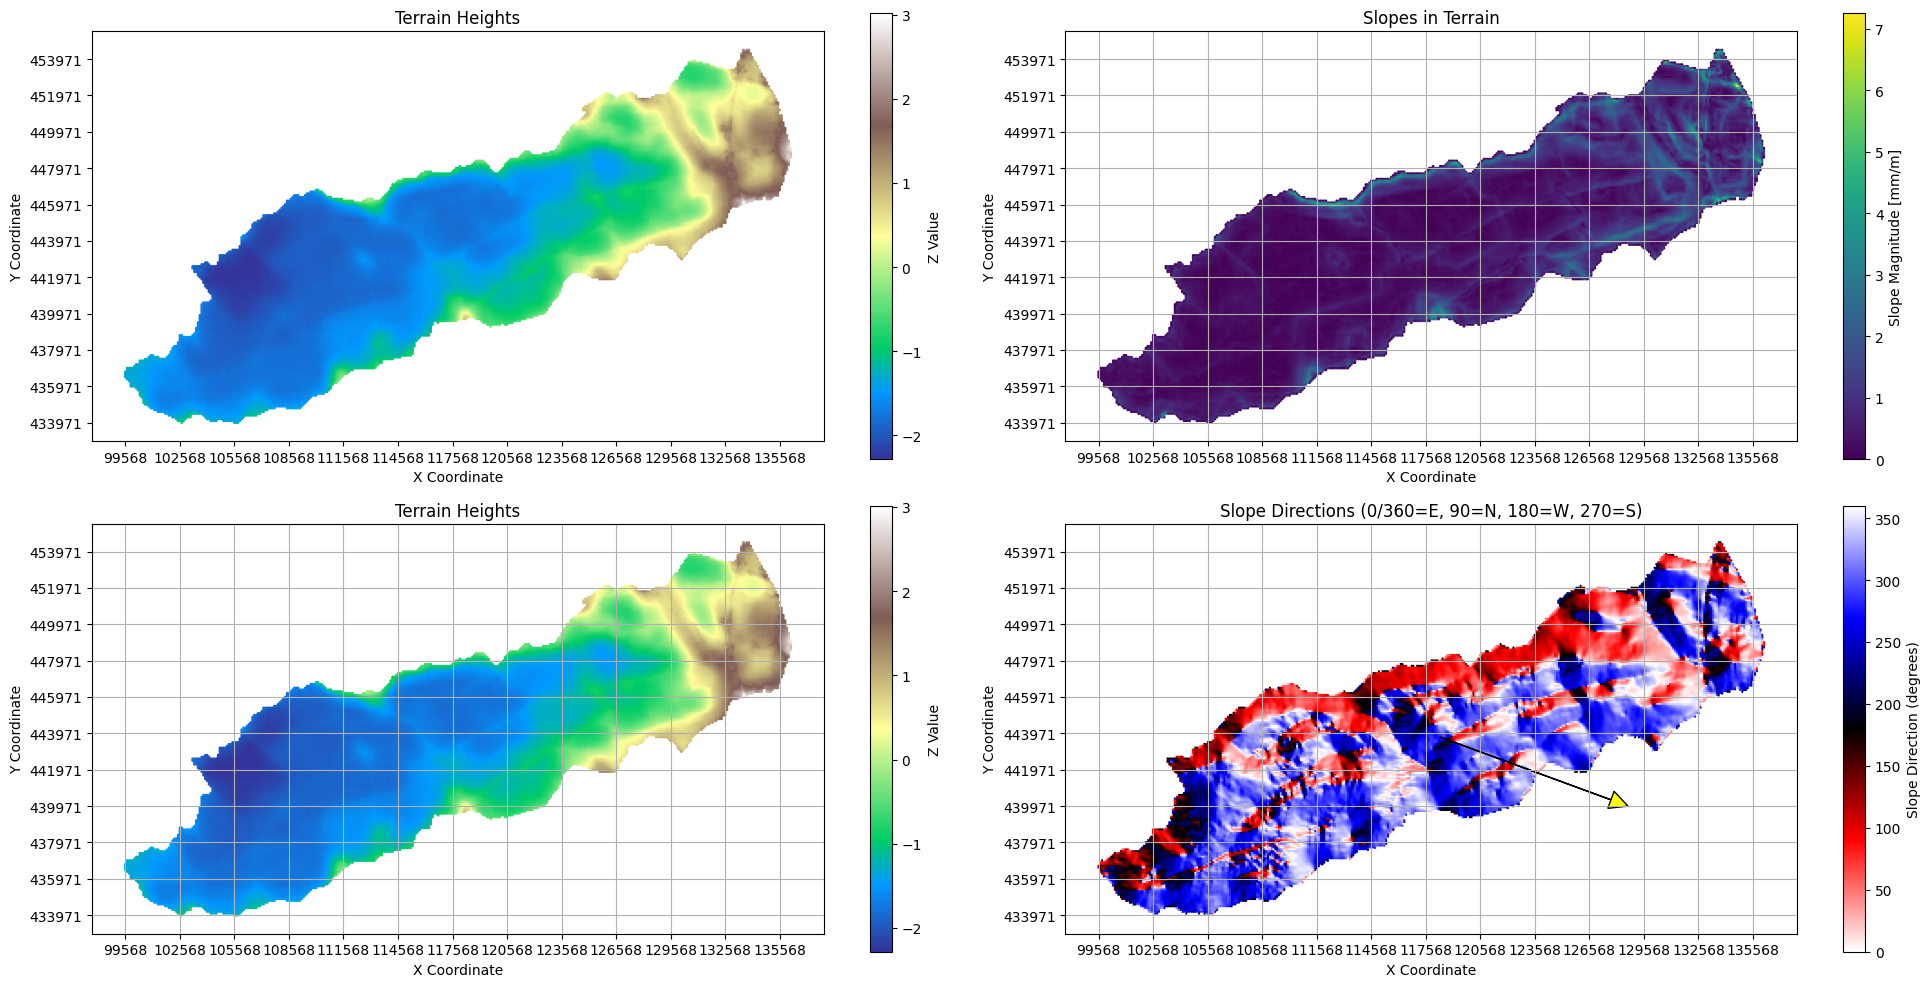

In [6]:
spatial_dict, centre_point = cma.DataPreparation(
    data_names=data_names,
    time_step=time_step,
    amount_sims=amount_sims,
    Dataset=Dataset
).spatial_dict()

cma.GeneralPlotting(
    spatial_dict=spatial_dict,
    centre_point=centre_point
).plot_terrain_slopes_and_directions()

# Clustering
To ensure the NPBN doesn't have 30k nodes we cluster the data. We first perform spatial clustering to ensure that we avoid nonsense connections/correlations in the domain, than we perform clustering based on the values.

### Spatial based clustering

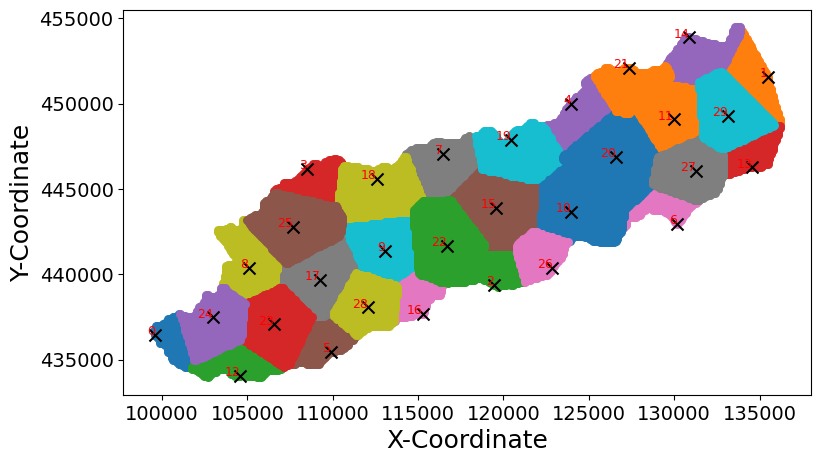

In [7]:
if NoSpatialClus == False:
    spatial_labels = cma.SpatialClustering(
        xy_coords=cma.np.array([spatial_dict['x'], spatial_dict['y']]).T,
        M=M
    ).cluster(Plot=True, show_elbow_curve=False, max_M=None)

### Value based clustering

In [8]:
clusters, avg_z_values_array, avg_slopes, weighted_avg_directions, gmm_params_per_cluster = cma.ValueClustering(
    spatial_labels=spatial_labels,
    method=method,
    parameter=parameter,
    spatial_dict=spatial_dict,
    NoSpatialClus = NoSpatialClus
).cluster()

In [9]:
# # Export GMM parameters per cluster to Excel
# gmm_params_per_cluster.to_excel('gmm_params_per_cluster.xlsx', index=False)

### Silhouette score

In [10]:
# avg_scores = cma.ValueClustering(
#     spatial_labels=spatial_labels,
#     method=method,
#     parameter=parameter,
#     spatial_dict=spatial_dict,
#     NoSpatialClus=NoSpatialClus
# ).silhouette_score_curve_per_spatial(k_range=range(2, 10))

# Postprocessing Clustered Data

In [11]:
cluster_DF, max_clus_DF, avg_z_values_array = cma.PostProcessClustering(
    clusters=clusters,
    spatial_dict=spatial_dict,
    num_startingpoints=num_startingpoints,
    avg_z_values_array=avg_z_values_array,
    data_names=data_names,
    avg_slopes=avg_slopes,
    weighted_avg_directions=weighted_avg_directions,
).post_process()

### Visualizing post-processed data

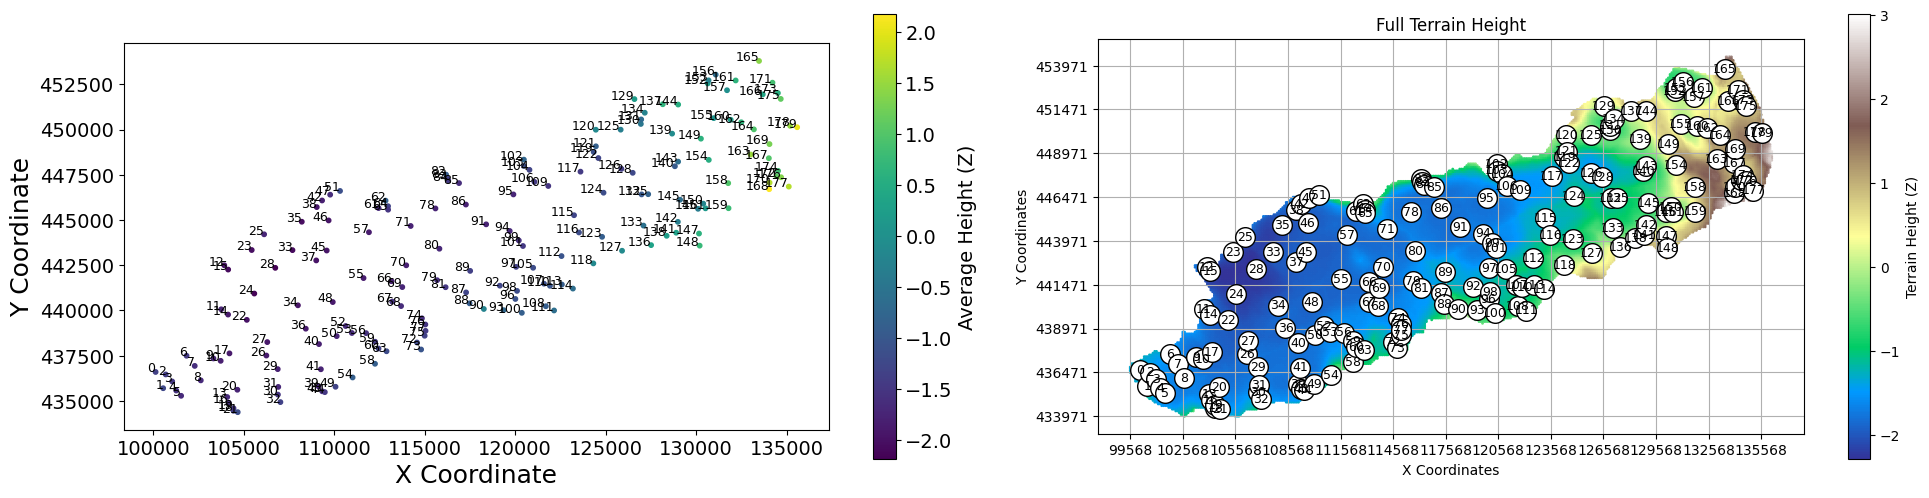

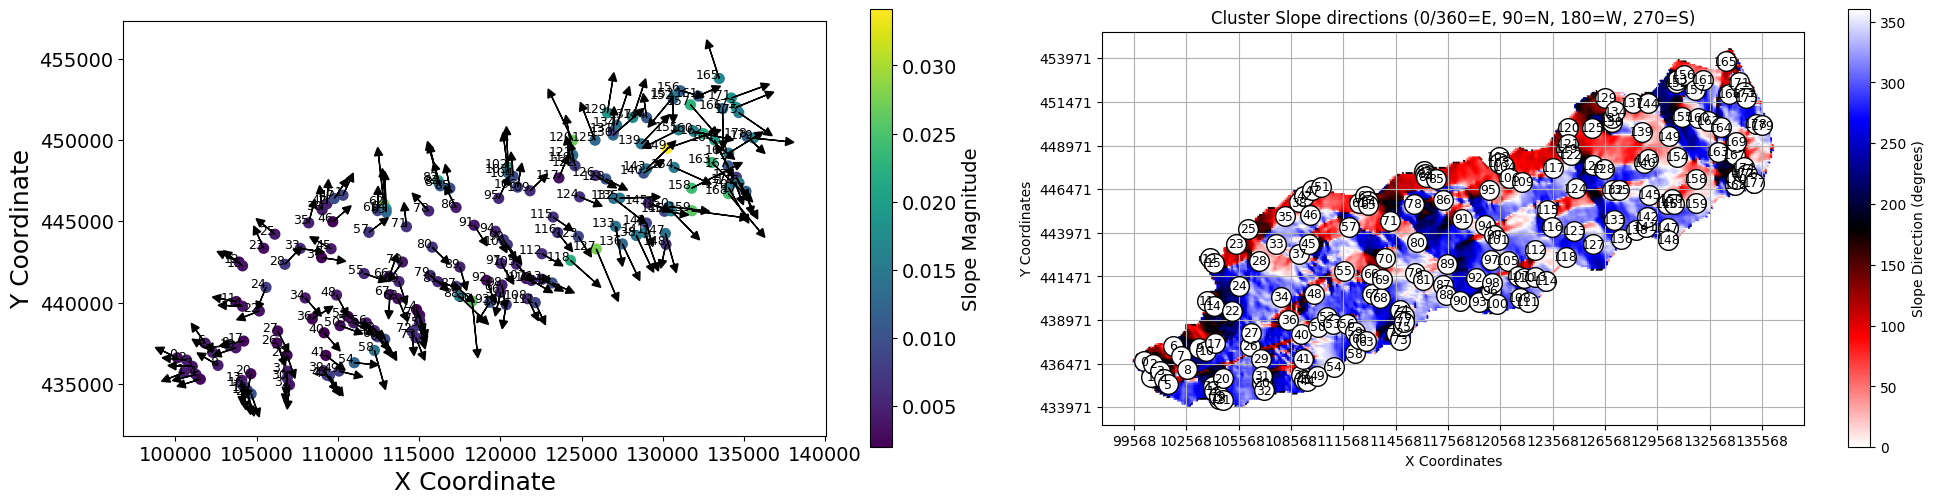

In [12]:
cma.ClusterPlotting(
    cluster_df=cluster_DF,
    spatial_dict=spatial_dict,
    colorbar=True,
    index=True
).plot_heights()

cma.ClusterPlotting(
    cluster_df=cluster_DF,
    spatial_dict=spatial_dict,
    colorbar=True,
    index=True
).plot_slopes()

# Constructing DAG
Using kNN to construct the arcs between the nodes. To prevent links to be made both ways we check the directions of the childs and the parents, and use the family tree constructed using the `networkx` package.

### Initialize using round 0 Adoption

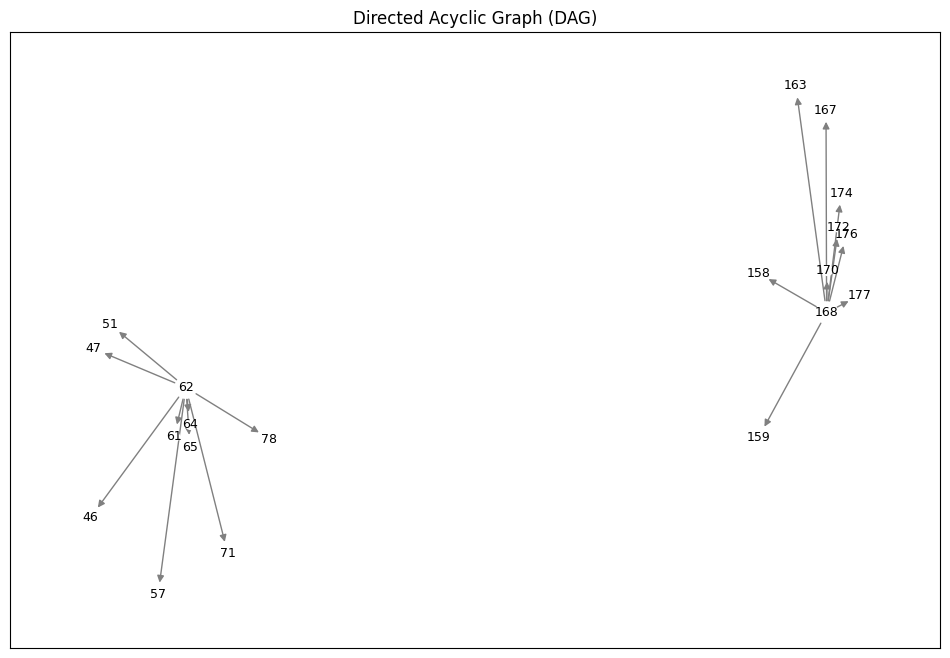

In [13]:
parent_child_dict_0, dag = cma.Adoption(
    max_clus_df=max_clus_DF,
    cluster_df=cluster_DF,
    kNN_k=kNN_k,
    max_distance=max_distance,
    Plot=False,
    max_iterations=max_iterations,
    extra_children=extra_children,
    num_startingpoints=num_startingpoints
).round_0_adoption()

parent_child_dict_total = parent_child_dict_0

### Continue using repeated Adoption

In [14]:
dag, parent_child_dict_total_old = cma.Adoption(
    max_clus_df=max_clus_DF,
    cluster_df=cluster_DF,
    kNN_k=kNN_k,
    max_distance=max_distance,
    Plot=False,
    max_iterations=max_iterations,
    extra_children=extra_children
).repeated_adoption(dag, parent_child_dict_0, parent_child_dict_total)

Iteration 1: Performing round_1_adoption, total_nodes = 180 & len(dag.nodes) =                 20
Iteration 2: Performing round_2_adoption, total_nodes = 180 & len(dag.nodes) =                 55
Iteration 3: Performing round_3_adoption, total_nodes = 180 & len(dag.nodes) =                 105
Iteration 4: Performing round_4_adoption, total_nodes = 180 & len(dag.nodes) =                 151
Iteration 5: Performing round_5_adoption, total_nodes = 180 & len(dag.nodes) =                 168
All nodes are connected after 6 adoption rounds.


### Visualizing final DAG

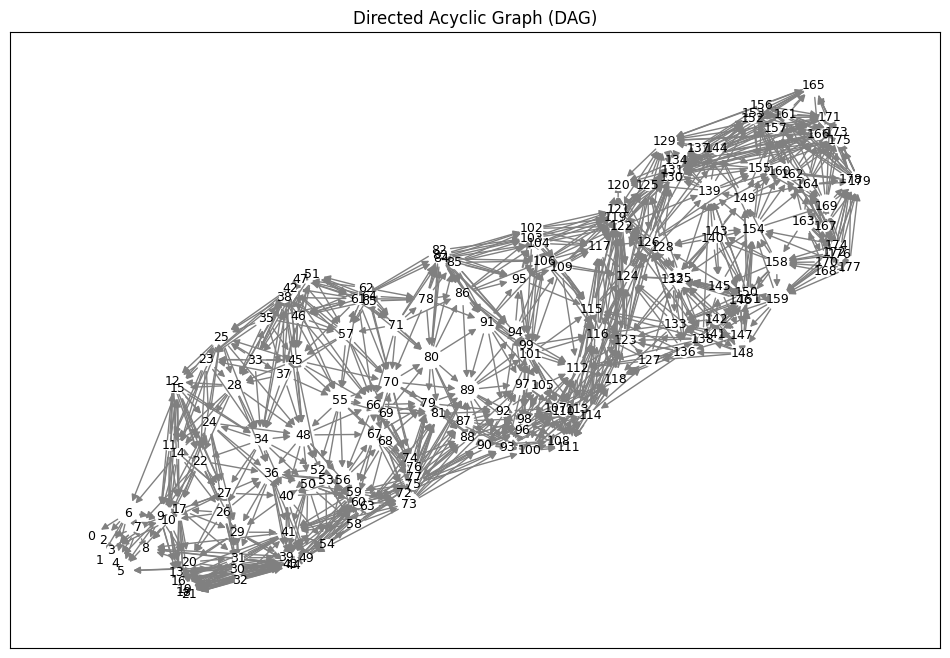

In [15]:
cma.DAGPlotting(
    dag=dag,
    cluster_df=cluster_DF
).visualize_dag()

# Transforming data for PyBanshee
To ensure the PyBanshee package works, the data has to be transformed into correct format.

In [16]:
data_DF, parents, names, child_parent_dict_total = cma.PyBansheePreparation(
    parent_child_dict_total=parent_child_dict_total,
    dag=dag,
    avg_z_values_array=avg_z_values_array
).pybanshee_prep()

### Example pair plots checking dependency structure

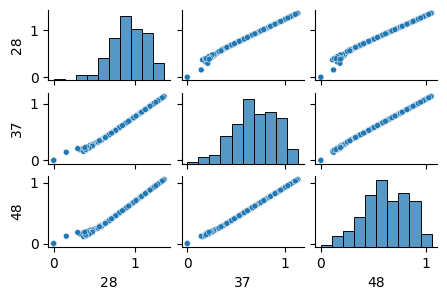

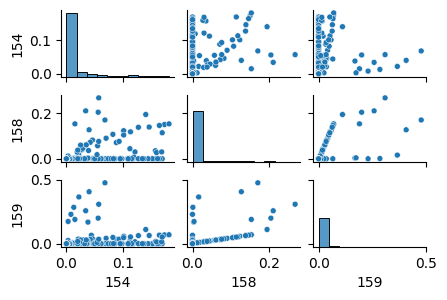

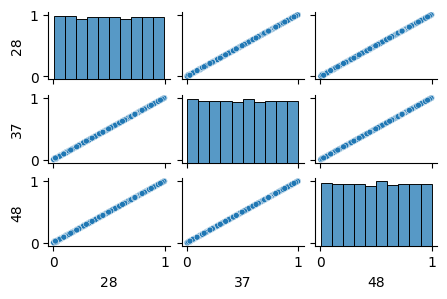

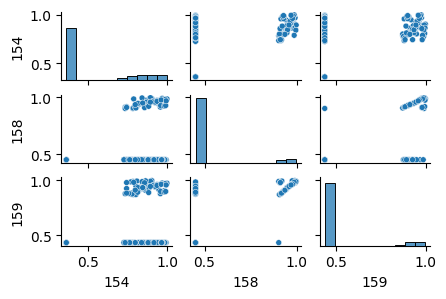

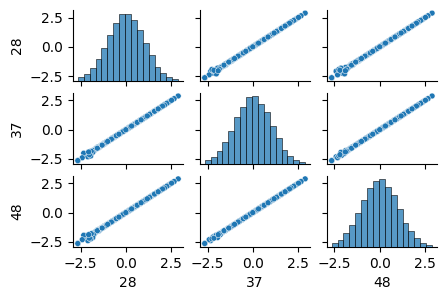

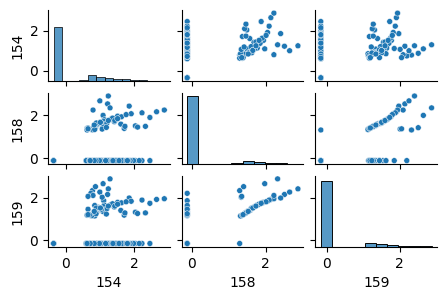

In [17]:
check_dependence_DF = data_DF[[28, 37, 48, 154, 158, 159]].clip(lower=0).round(3)


# RAW PAIR PLOTS
cma.sns.pairplot(check_dependence_DF[[28, 37, 48]], height=1, aspect=1.5, plot_kws=dict(size=.1), diag_kws=dict(bins=10, stat='density'))
cma.sns.pairplot(check_dependence_DF[[154, 158, 159]], height=1, aspect=1.5, plot_kws=dict(size=.1), diag_kws=dict(bins=10, stat='density'))

def unity(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0, method="average") # Step 1 in PIT transformation
    u_hat = ranks / (M + 1) # Step 2 in PIT transformation
    return u_hat

unity_data = unity(check_dependence_DF)

# UNITY PAIR PLOTS
cma.sns.pairplot(unity_data[[28, 37, 48]], height=1, aspect=1.5, plot_kws=dict(size=.1))
cma.sns.pairplot(unity_data[[154, 158, 159]], height=1, aspect=1.5, plot_kws=dict(size=.1))

def sd_normal(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0) # Step 1 in PIT transformation
    u_hat = ranks / (M + 1) # Step 2 in PIT transformation
    sd_data = cma.stats.norm.ppf(u_hat) # Applying the inverse of the standard normal distribution
    return sd_data

sd_data = cma.pd.DataFrame(sd_normal(check_dependence_DF), columns = check_dependence_DF.columns)

# STANDARD NORMAL SPACE PAIR PLOTS
cma.sns.pairplot(sd_data[[28, 37, 48]], height=1, aspect=1.5, plot_kws=dict(size=.1))
cma.sns.pairplot(sd_data[[154, 158, 159]], height=1, aspect=1.5, plot_kws=dict(size=.1))

# Validation
To validate the NPBN we compare the rank correlation matrices of the emperical, saturated and constructed networks (both visually and using a distance metric). Using the $d_G$ metric, various distances can be calculated, each representing different goodness-of-fit characteristics of the model.

#### Copula Performance

To evaluate whether the chosen copula family is a good estimator for the system, the distance between the RCM of the empirical data and the RCM of the fully saturated model can be determined:  
$$
RCM_{emp} - RCM_{sat}
$$  
If this distance is substantial, it may indicate the need to consider a different copula family for use within the Bayesian Network (BN).

#### NPBN Performance

To assess whether the constructed DAG and its semantics effectively describe the relationships within the data, the distance between the saturated RCM (representing the best-case DAG, albeit overfit) and the RCM of the NPBN should be calculated:  
$$
RCM_{sat} - RCM_{NPBN}
$$  
If this distance is significant, adjustments to the semantics of the DAG may be necessary.

#### NPBN Raw Performance

To evaluate the raw performance of the NPBN, the distance between the RCM of the empirical data and the RCM of the NPBN can be calculated:  
$$
RCM_{emp} - RCM_{NPBN}
$$

In [18]:
emp_RCM, p_emp = cma.RCMConstructor(
    data_DF=data_DF,
    parents=parents,
    names=names,
    child_parent_dict_total=child_parent_dict_total
).emp_rcm()

sat_RCM = cma.RCMConstructor(
    data_DF=data_DF,
    parents=parents,
    names=names,
    child_parent_dict_total=child_parent_dict_total
).sat_rcm()

NPBN_RCM = cma.RCMConstructor(
    data_DF=data_DF,
    parents=parents,
    names=names,
    child_parent_dict_total=child_parent_dict_total
).npbn_rcm()

### Exporting final model for model testing

In [19]:
# # Save relevant data for testing -> toggle on/off
# cma.np.save('Optimal_Config/NPBN_RCM.npy', NPBN_RCM)
# cma.np.save('Optimal_Config/spatial_dict.npy', spatial_dict)
# data_DF.to_parquet('Optimal_Config/data_DF.parquet')
# cluster_DF.to_parquet('Optimal_Config/cluster_DF.parquet')

### Visualizing RCMs

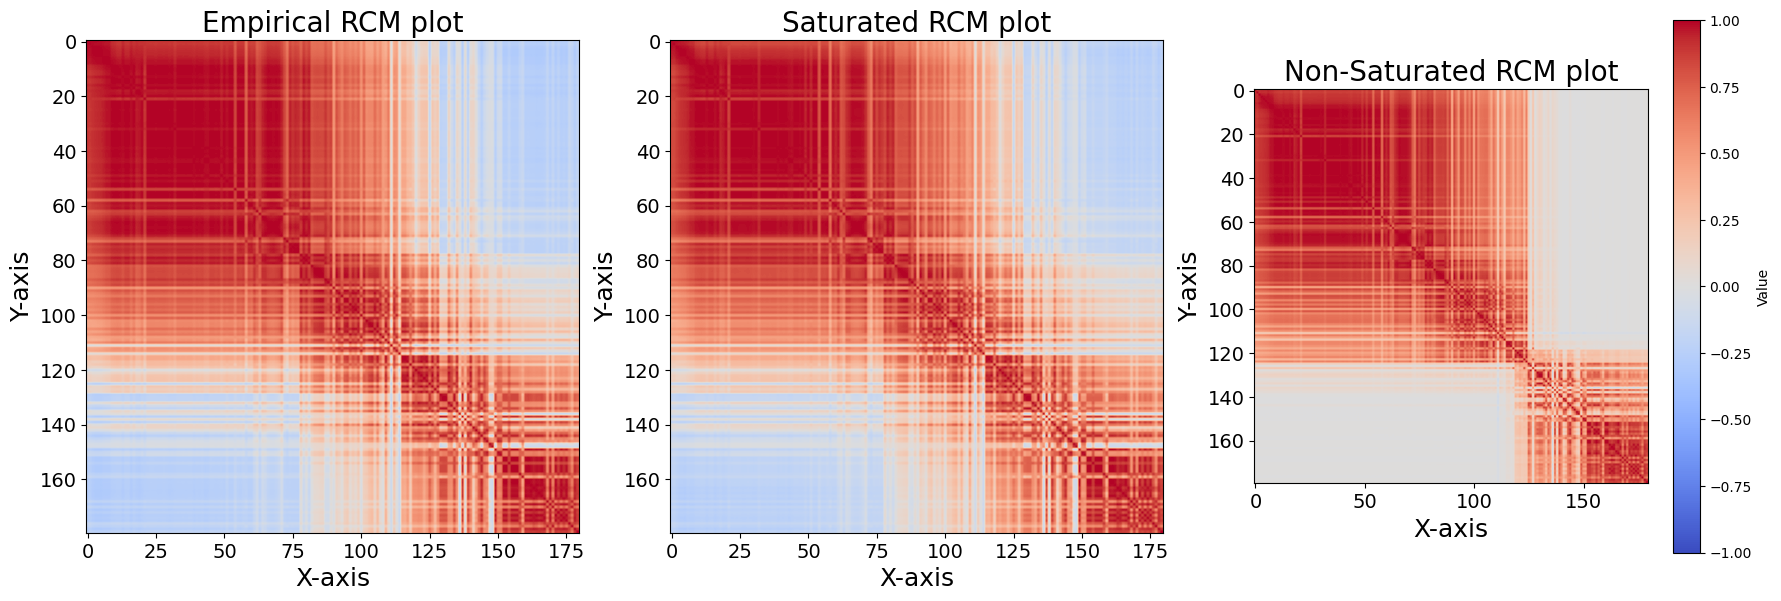

In [20]:
cma.RCMPlotting(
    emp_RCM=emp_RCM,
    sat_RCM=sat_RCM,
    NPBN_RCM=NPBN_RCM
).rcm_triple_plot()

# # Nicer plots for single RCMs in report

# cma.RCMPlotting(
#     emp_RCM=emp_RCM,
#     sat_RCM=sat_RCM,
#     NPBN_RCM=NPBN_RCM
# ).rcm_single_plot('emp')

# cma.RCMPlotting(
#     emp_RCM=emp_RCM,
#     sat_RCM=sat_RCM,
#     NPBN_RCM=NPBN_RCM
# ).rcm_single_plot('sat')

# cma.RCMPlotting(
#     emp_RCM=emp_RCM,
#     sat_RCM=sat_RCM,
#     NPBN_RCM=NPBN_RCM
# ).rcm_single_plot('NPBN')

### Plotting the difference between emp and sat rcm

In [21]:
# import matplotlib.pyplot as plt

# diff_RCM = (emp_RCM - sat_RCM)**2

# plt.figure(figsize=(8, 6))
# # plt.imshow(diff_RCM, cmap='jet', vmin=cma.np.min(diff_RCM), vmax=cma.np.max(diff_RCM))
# plt.imshow(diff_RCM, cmap='Reds', vmin=0, vmax=0.06)
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=14)
# cbar.set_label(r"$\left(\mathrm{emp}_{\mathrm{RCM}} - \mathrm{sat}_{\mathrm{RCM}}\right)^2$", fontsize=16)
# # plt.title("Difference: Empirical RCM - Saturated RCM")
# plt.xlabel("X-axis", fontsize=18)
# plt.ylabel("Y-axis", fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

### Numerical values distance metric

In [22]:
dis_metric_EmpSat = cma.DistanceMetric(
    emp_RCM=emp_RCM,
    sat_RCM=sat_RCM,
    NPBN_RCM=NPBN_RCM,
    data_DF=data_DF
).emp_sat()

dis_metric_SatNPBN = cma.DistanceMetric(
    emp_RCM=emp_RCM,
    sat_RCM=sat_RCM,
    NPBN_RCM=NPBN_RCM,
    data_DF=data_DF
).sat_npbn()

dis_metric_EmpNPBN = cma.DistanceMetric(
    emp_RCM=emp_RCM,
    sat_RCM=sat_RCM,
    NPBN_RCM=NPBN_RCM,
    data_DF=data_DF
).emp_npbn()

----------------------------------------------------------------------------------------------------
The d-calibration score between the emperical RCM and the saturated RCM is 20.79


----------------------------------------------------------------------------------------------------
The d-calibration score between the saturated RCM and the NPBN RCM is 22.66


----------------------------------------------------------------------------------------------------
The d-calibration score between the emperical RCM and the saturated RCM is 33.72




# Inference example results; local distributions

More examples in `Compare_test_set.ipynb`.

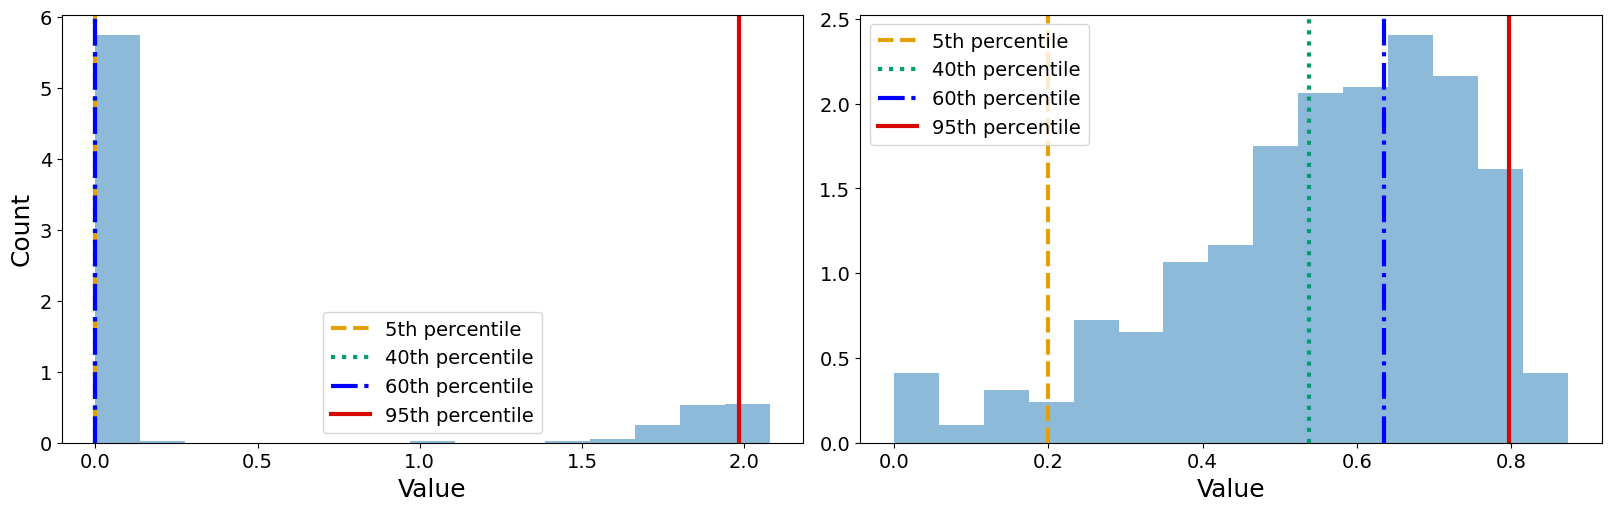

In [26]:
condition_nodes = []
condition_values = []

F = cma.inference(Nodes = condition_nodes,
            Values = condition_values,
            R=NPBN_RCM,
            DATA=data_DF,
            empirical_data=True, 
            SampleSize=1000,
            Output='full')[0]

fig, axes = cma.plt.subplots(1,2, figsize=(16, 5), layout='constrained')

percentiles = [5, 40, 60, 95]
colors = ["#E69F00", "#009E73", 'blue', "#D50700"]
styles = ['--', ':', '-.', '-']

data_cond_156 = F[155]
data_uncond_156 = data_DF.iloc[:,156]

for p, c, s in zip(percentiles, colors, styles):
    val = cma.np.percentile(data_uncond_156, p)
    axes[0].axvline(val,color=c, linestyle=s, linewidth=3, label=f'{p}th percentile')
# axes[0].hist(data_cond_156, bins=50, density=True, label='Conditional')
axes[0].hist(data_uncond_156, bins=15, density=True, alpha=0.5)
axes[0].set_ylabel('Count', fontsize=18)
axes[0].set_xlabel('Value', fontsize=18)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].legend(fontsize=14)

data_cond_94 = F[93]
data_uncond_94 = data_DF.iloc[:,94]

for p, c, s in zip(percentiles, colors, styles):
    val = cma.np.percentile(data_uncond_94, p)
    axes[1].axvline(val,color=c, linestyle=s, linewidth=3, label=f'{p}th percentile')
# axes[1].hist(data_cond_94, bins=50, density=True, label='Conditional')
axes[1].hist(data_uncond_94, bins=15, density=True, alpha=0.5)
axes[1].set_xlabel('Value', fontsize=18)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].legend(fontsize=14)

# Runtime

In [24]:
end_time = time.time()
total_time = end_time - start_time 

print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 372.45 seconds


# Export to excel

In [25]:
# total_clusters = len(cluster_DF)

# # Data to summarize
# data = {
#     "seed": [seed],
#     "method": [method],
#     "NoSpatialClus": ['true' if NoSpatialClus==True else 'false'],
#     "extra_children": ['true' if extra_children==True else 'false'],
#     "M": [M],
#     "parameter": [parameter],
#     "total_clusters": [total_clusters],
#     "num_startingpoints": [num_startingpoints],
#     "kNN_k": [kNN_k],
#     "d_cal_dist_emp_sat": [dis_metric_EmpSat],
#     "d_cal_dist_sat_npbn": [dis_metric_SatNPBN],
#     "d_cal_dist_emp_npbn": [dis_metric_EmpNPBN],
#     'total_time': total_time,
#     "error": 'no error'
# }

# # Create a DataFrame
# df = cma.pd.DataFrame(data)

# display(df)

# # Load the existing workbook or create a new one if it doesn't exist
# try:
#     workbook = cma.openpyxl.load_workbook('Output.xlsx')
# except FileNotFoundError:
#     workbook = cma.openpyxl.Workbook()

# # Determine the sheet to update based on the method
# sheet_name = 'GMM' if df['method'][0] == 'GMM' else 'DBSCAN'

# # Check if the sheet exists; if not, create it
# if sheet_name not in workbook.sheetnames:
#     sheet = workbook.create_sheet(sheet_name)
# else:
#     sheet = workbook[sheet_name]

# # Find the first empty row in the sheet
# start_row = sheet.max_row + 1

# # Append the DataFrame to the sheet
# for row in df.itertuples(index=False, name=None):
#     sheet.append(row)

# # Save the workbook
# workbook.save('Output.xlsx')
# print("Excel file updated successfully!")